In [2]:
import findspark
findspark.init()

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

In [3]:
# %cd '/content/gdrive/My Drive/LDS9/Practice/Chapter5/'

In [3]:
# import libraries
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
from pyspark.sql import Row
import pyspark.sql.functions as f

import pyspark.sql.types as t

import pyspark.ml.feature as feat

import numpy as np
import pandas as pd

# Pipeline
from pyspark.ml import Pipeline, PipelineModel

# Machine learning
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Cross validation 
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


In [5]:
# import os
# import sys

# os.environ['PYSPARK_PYTHON'] = sys.executable
# os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

# About Dataset
Build a clustering model to cluster the movies in tmdb_5000_movies.csv dataset.

Explain the main characteristics of each cluster. Use Word Cloud to visualize each
cluster.

**(Hint: Use some features such as 'title', 'tagline', 'overview', 'popularity'…)**


In [4]:
SparkContext.setSystemProperty(key='spark.hadoop.dfs.client.use.datanode.hostname',value='true')

In [5]:
sc =SparkContext()

In [6]:
sc.setLogLevel("ERROR")

In [7]:
spark = SparkSession(sc)

In [8]:
df = spark.read.csv('data/tmdb_5000_movies.csv',inferSchema=True,header=True)

In [18]:
df.select('title', 'tagline', 'overview', 'popularity','vote_average', 'vote_count').show(5)

+---------------+--------------------+--------------------+--------------------+--------------------+----------------+
|          title|             tagline|            overview|          popularity|        vote_average|      vote_count|
+---------------+--------------------+--------------------+--------------------+--------------------+----------------+
|  {""id"": 3388| ""name"": ""spac...|        {""id"": 878| ""name"": ""Scie...| ""name"": ""spac...|   {""id"": 3679|
|  {""id"": 2038| ""name"": ""east...|http://disney.go....|                 285| ""name"": ""love...|   {""id"": 2052|
| {""id"": 14555| ""name"": ""sequ...|http://www.sonypi...|              206647|  ""name"": ""mi6""}| {""id"": 156095|
|  {""id"": 1308| ""name"": ""terr...|         {""id"": 53| ""name"": ""Thri...| ""name"": ""secr...|   {""id"": 1437|
|  {""id"": 7376| ""name"": ""spac...|http://movies.dis...|               49529| ""name"": ""prin...|   {""id"": 9951|
+---------------+--------------------+----------

# Overview

In [16]:
df.show(1,vertical=False,truncate=True)
df.printSchema()
print(f'There are {df.count()} rows and {len(df.columns)} columns in dataframe')

+---------+-------------+--------------------+------------+--------------------+-----------------+--------------------+-------------+--------------------+--------------------+--------------------+---------------+--------------------+--------------+--------------------+--------------+--------------------+--------------+--------------------+--------------+
|   budget|       genres|            homepage|          id|            keywords|original_language|      original_title|     overview|          popularity|production_companies|production_countries|   release_date|             revenue|       runtime|    spoken_languages|        status|             tagline|         title|        vote_average|    vote_count|
+---------+-------------+--------------------+------------+--------------------+-----------------+--------------------+-------------+--------------------+--------------------+--------------------+---------------+--------------------+--------------+--------------------+--------------+--

## check null

In [13]:
df.select([f.count(f.when(f.isnan(c), c)).alias(c) for c in df.columns]).show()

+------+------+--------+---+--------+-----------------+--------------+--------+----------+--------------------+--------------------+------------+-------+-------+----------------+------+-------+-----+------------+----------+
|budget|genres|homepage| id|keywords|original_language|original_title|overview|popularity|production_companies|production_countries|release_date|revenue|runtime|spoken_languages|status|tagline|title|vote_average|vote_count|
+------+------+--------+---+--------+-----------------+--------------+--------+----------+--------------------+--------------------+------------+-------+-------+----------------+------+-------+-----+------------+----------+
|     0|     0|       0|  0|       0|                0|             0|       0|         0|                   0|                   0|           0|      0|      0|               0|     0|      0|    0|           0|         0|
+------+------+--------+---+--------+-----------------+--------------+--------+----------+--------------

In [14]:
df.select([f.count(f.when(f.isnull(c), c)).alias(c) for c in df.columns]).show()

+------+------+--------+---+--------+-----------------+--------------+--------+----------+--------------------+--------------------+------------+-------+-------+----------------+------+-------+-----+------------+----------+
|budget|genres|homepage| id|keywords|original_language|original_title|overview|popularity|production_companies|production_countries|release_date|revenue|runtime|spoken_languages|status|tagline|title|vote_average|vote_count|
+------+------+--------+---+--------+-----------------+--------------+--------+----------+--------------------+--------------------+------------+-------+-------+----------------+------+-------+-----+------------+----------+
|     0|     0|      23|613|       0|              961|             0|     926|         1|                 425|                   0|         121|      0|     20|               1|     5|     13|   12|          16|        24|
+------+------+--------+---+--------+-----------------+--------------+--------+----------+--------------

## Descirble data

In [15]:
cat_col = ['Geography', 'Gender', 'Tenure','NumOfProducts', 'HasCrCard','IsActiveMember','Exited']
cat_col

['Geography',
 'Gender',
 'Tenure',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'Exited']

In [16]:
numeric_col = [k for k,v in dict(df.dtypes).items() if not (v=='string' or v=='timestamp') and not k in cat_col]
numeric_col = numeric_col[2:] 
numeric_col

['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

In [17]:
df.select(numeric_col).describe().show()

+-------+-----------------+------------------+-----------------+-----------------+
|summary|      CreditScore|               Age|          Balance|  EstimatedSalary|
+-------+-----------------+------------------+-----------------+-----------------+
|  count|            10000|             10000|            10000|            10000|
|   mean|         650.5288|           38.9218|76485.88928799961|100090.2398809998|
| stddev|96.65329873613035|10.487806451704587|62397.40520238599|57510.49281769821|
|    min|              350|                18|              0.0|            11.58|
|    max|              850|                92|        250898.09|        199992.48|
+-------+-----------------+------------------+-----------------+-----------------+



## Category data

### Check distinct values

In [18]:
df.select([f.count_distinct(c).alias(c) for c in df.columns if c not in numeric_col]).show()

+---------+----------+-------+---------+------+------+-------------+---------+--------------+------+
|RowNumber|CustomerId|Surname|Geography|Gender|Tenure|NumOfProducts|HasCrCard|IsActiveMember|Exited|
+---------+----------+-------+---------+------+------+-------------+---------+--------------+------+
|    10000|     10000|   2932|        3|     2|    11|            4|        2|             2|     2|
+---------+----------+-------+---------+------+------+-------------+---------+--------------+------+



- Remove some columns is not appropriate for model: `RowNumber, RowNumber, Surname `because it can cause **the curse of dimensionality**

In [19]:
df_final = df.drop('RowNumber','CustomerId','Surname')

### Check top5 disticnt value count of each category columns in df 

In [20]:
for col in cat_col:
    (df.groupby(col).count()
     .withColumn('Normalize',(f.col('count')/df_final.count()))
     .orderBy(f.col('count').desc())
     .show(5,vertical=False,truncate=False))

+---------+-----+---------+
|Geography|count|Normalize|
+---------+-----+---------+
|France   |5014 |0.5014   |
|Germany  |2509 |0.2509   |
|Spain    |2477 |0.2477   |
+---------+-----+---------+

+------+-----+---------+
|Gender|count|Normalize|
+------+-----+---------+
|Male  |5457 |0.5457   |
|Female|4543 |0.4543   |
+------+-----+---------+

+------+-----+---------+
|Tenure|count|Normalize|
+------+-----+---------+
|2     |1048 |0.1048   |
|1     |1035 |0.1035   |
|7     |1028 |0.1028   |
|8     |1025 |0.1025   |
|5     |1012 |0.1012   |
+------+-----+---------+
only showing top 5 rows

+-------------+-----+---------+
|NumOfProducts|count|Normalize|
+-------------+-----+---------+
|1            |5084 |0.5084   |
|2            |4590 |0.459    |
|3            |266  |0.0266   |
|4            |60   |0.006    |
+-------------+-----+---------+

+---------+-----+---------+
|HasCrCard|count|Normalize|
+---------+-----+---------+
|1        |7055 |0.7055   |
|0        |2945 |0.2945   |
+----

In [21]:
df_final = df_final.withColumnRenamed('Exited','label')

Besides, As can been seen, the label column has imbalanced data => use SMOTE to handle data

| Exited | count|
|------- |------|
| 0      | 7963 |
| 1      | 2037 |

In [22]:
positive_class_label = 1

# Count the occurrences of the minority class
minority_count = df_final.filter(df_final.label == positive_class_label).count()

# Count the occurrences of the majority class
majority_count = df_final.filter(df_final.label != positive_class_label).count()

# Calculate the ratio between majority and minority class
class_ratio = majority_count / minority_count

# Calculate the class weights
class_weights = {positive_class_label: 1.0, 0: class_ratio}
class_weights

{1: 1.0, 0: 3.9091801669121256}

## Numeric data

## Check skewness

In [23]:
df_final.select([f.skewness(c) for c in numeric_col]).show()

+---------------------+------------------+-------------------+-------------------------+
|skewness(CreditScore)|     skewness(Age)|  skewness(Balance)|skewness(EstimatedSalary)|
+---------------------+------------------+-------------------+-------------------------+
| -0.07159586676212142|1.0111685586628147|-0.1410875437529113|     0.002085044844874...|
+---------------------+------------------+-------------------+-------------------------+



There is a high skewness => use MinMax scaler

## Coeffiecient Correlation 

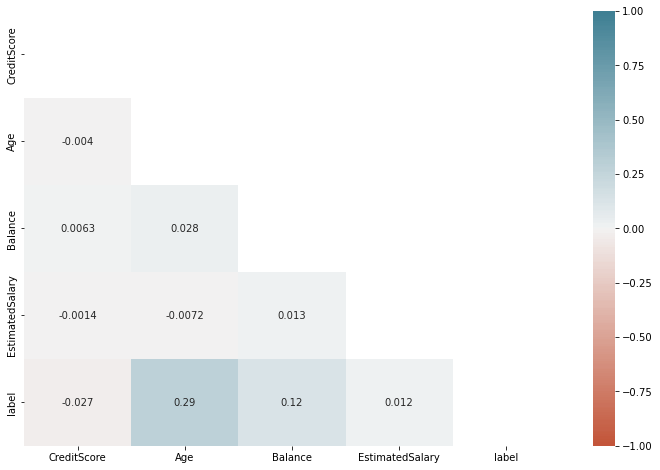

In [24]:
corr = df_final.select([c for c in df_final.columns if c not in cat_col]).toPandas().corr(numeric_only=True)
mask_ut=np.triu(np.ones(corr.shape)).astype(bool)
plt.figure(figsize=(12,8))
sns.heatmap(corr,
            annot=True,
            vmin=-1,center=0,vmax=1,
            cmap=sns.diverging_palette(20, 220, n=200),
            mask=mask_ut)
plt.show()

There is not the significant coefficient correlation

From what I have seen: 
- nominal data: 'Geography'
- ordinal data: 'Tenure', 'NumOfProducts'
- binary data: 'Gender', 'HasCrCard', 'IsActiveMember'
- numeric data: 'CreditScore', 'Age', 'EstimatedSalary'
- Target: 'label'

=> There are 2 cols: Geography and Gender which are not formated to standard type

# Preprocessing

## Split Data

In [25]:
df_final.show(1)
df_final.printSchema()

+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+-----+
|CreditScore|Geography|Gender|Age|Tenure|Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|label|
+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+-----+
|        619|   France|Female| 42|     2|    0.0|            1|        1|             1|      101348.88|    1|
+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+-----+
only showing top 1 row

root
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = tru

In [26]:
train_data, test_data = df_final.randomSplit([0.8,0.2],seed=42)

## one hot encoding the nominal data

In [51]:
# String to index according to frequencyDesc
fre_indexer = feat.StringIndexer(inputCols=['Geography', 'Gender'],
                             outputCols=['geo_idx','gender_idx'],
                             handleInvalid='keep',
                             stringOrderType='frequencyDesc')


#  one hot encoding the nominal data
ohe_encoder = feat.OneHotEncoder(inputCols= ['geo_idx','gender_idx'], 
                                 outputCols=['geo_ohe','gender_ohe'],
                                 handleInvalid='keep',
                                 dropLast=True)



# Scaling the numeric features 
va = feat.VectorAssembler(inputCols=['CreditScore', 'Age', 'EstimatedSalary'], outputCol="num_feature")
scaler1 = feat.RobustScaler(inputCol='num_feature',outputCol='robust_scale')

# Assemble features into a vector 
assembler = feat.VectorAssembler(inputCols=['Tenure', 'NumOfProducts', # ordinal
                                            'geo_ohe','gender_ohe', # ohe
                                            'HasCrCard', 'IsActiveMember', # binary
                                            'robust_scale'], # numeric
                                 outputCol='features')

## Build Pipeline

In [125]:
# Build Pipiline and train data
pre_pipeline = Pipeline(stages=[fre_indexer,
                             ohe_encoder,
                             va,
                             scaler1,
                             assembler])

In [126]:
pre_pipeline = pre_pipeline.fit(train_data)
pre_train_data = pre_pipeline.transform(train_data).select('features','label')


## Handle Imbalanced data

In [32]:
X_train, y_train = zip(*pre_train_data.rdd.map(lambda row: (row['features'], row['label'])).collect())
oversampler = SMOTE(sampling_strategy='auto', random_state=42)
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

In [33]:
pd.DataFrame(y_train_oversampled).value_counts()

0    6448
1    6448
dtype: int64

In [46]:
data = [Row(features=Vectors.dense(f),label=int(l)) for f, l in zip(X_train_oversampled,y_train_oversampled)]
data[0]

Row(features=DenseVector([0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.5926, 3.3333, 1.7458]), label=1)

In [52]:
train_oversampling = spark.createDataFrame(data)
train_oversampling.show(1,False)

+----------------------------------------------------------------------------------------------------+-----+
|features                                                                                            |label|
+----------------------------------------------------------------------------------------------------+-----+
|[0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2.5925925925925926,3.333333333333333,1.745814461507351]|1    |
+----------------------------------------------------------------------------------------------------+-----+
only showing top 1 row



- Train the over sampling data

In [58]:
#Pipeline(stages=[pre_pipeline,lo_clf]).fit(train_data)

In [65]:
# Build Pipiline and train data
lo_clf = LogisticRegression(featuresCol='features', labelCol='label', predictionCol='prediction')

rf_clf = RandomForestClassifier(featuresCol='features', labelCol='label', predictionCol='prediction',seed=42)

# Train Data and Tune HyperParams

## Set up Params for cross valisation process

In [59]:
params_lo_clf =(ParamGridBuilder()
             .addGrid(lo_clf.regParam, [0.0,0.1 ,1.0])
             .addGrid(lo_clf.elasticNetParam, [0.0, 0.5],)
             .build())
params_rf_clf = (ParamGridBuilder()
             .addGrid(rf_clf.maxDepth, [5, 10,15])
             .addGrid(rf_clf.minInstancesPerNode, [2,4, 5])
             .addGrid(rf_clf.maxBins, [10,32])
             .build())

In [60]:
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')
binary_evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')

In [ ]:
#print(evaluator.explainParams())

In [66]:
lo_crossval = CrossValidator(estimator=lo_clf,
                              estimatorParamMaps=params_lo_clf,
                              evaluator=f1_evaluator,
                              numFolds=5)

rf_crossval = CrossValidator(estimator=rf_clf,
                              estimatorParamMaps=params_rf_clf,
                              evaluator=f1_evaluator,
                              numFolds=5)

In [67]:
lo_cv_model = lo_crossval.fit(train_oversampling)
rf_cv_model = rf_crossval.fit(train_oversampling)

In [70]:
best_lr_model = lo_cv_model.bestModel  # The last stage is the best model (LogisticRegression in this case)
print("Best regularization parameter (regParam):", best_lr_model.getRegParam())
print("Best elastic net parameter (elasticNetParam):", best_lr_model.getElasticNetParam())

Best regularization parameter (regParam): 0.0
Best elastic net parameter (elasticNetParam): 0.0


In [72]:
best_rf_model = rf_cv_model.bestModel  # The last stage is the best model (LogisticRegression in this case)
print("Best regularization parameter (regParam):", best_rf_model.getMaxDepth())
print("Best elastic net parameter (elasticNetParam):", best_rf_model.getMinInstancesPerNode())
print("Best elastic net parameter (elasticNetParam):", best_rf_model.getMaxBins())

Best regularization parameter (regParam): 5
Best elastic net parameter (elasticNetParam): 1
Best elastic net parameter (elasticNetParam): 32


In [73]:
eval_df = lo_cv_model.transform(train_oversampling)
eval_df.groupby('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0| 1884|
|    0|       1.0| 1829|
|    0|       0.0| 4619|
|    1|       1.0| 4564|
+-----+----------+-----+



# Evaluation

In [127]:
pre_test_data = pre_pipeline.transform(test_data)

In [80]:
lo_results = lo_cv_model.transform(pre_test_data).select('features','label','prediction')
rf_results = rf_cv_model.transform(pre_test_data).select('features','label','prediction')

## Confusion matrix of 2 models

In [86]:
lo_results.crosstab('label','prediction').withColumnsRenamed({'0.0':'prediction_0',
                                                           '1.0':'prediction_1',
                                                           'label_prediction':'true_label'}).show()

+----------+------------+------------+
|true_label|prediction_0|prediction_1|
+----------+------------+------------+
|         0|        1092|         423|
|         1|         129|         277|
+----------+------------+------------+



In [87]:
rf_results.crosstab('label','prediction').withColumnsRenamed({'0.0':'prediction_0',
                                                           '1.0':'prediction_1',
                                                           'label_prediction':'true_label'}).show()

+----------+------------+------------+
|true_label|prediction_0|prediction_1|
+----------+------------+------------+
|         0|        1247|         268|
|         1|         120|         286|
+----------+------------+------------+



- Random Forest give the better result with high True Positive and True Negative.

In [91]:
multi_evaluator = MulticlassClassificationEvaluator(predictionCol='prediction',labelCol='label')
# Random Forest
acc_rf = multi_evaluator.evaluate(rf_results,{multi_evaluator.metricName:'accuracy'})
precision_rf = multi_evaluator.evaluate(rf_results,{multi_evaluator.metricName:'weightedPrecision'})
recall_rf = multi_evaluator.evaluate(rf_results,{multi_evaluator.metricName:'weightedRecall'})
f1_rf = multi_evaluator.evaluate(rf_results,{multi_evaluator.metricName:'f1'})

# Logistic Regression
acc_lo = multi_evaluator.evaluate(lo_results,{multi_evaluator.metricName:'accuracy'})
precision_lo = multi_evaluator.evaluate(lo_results,{multi_evaluator.metricName:'weightedPrecision'})
recall_lo = multi_evaluator.evaluate(lo_results,{multi_evaluator.metricName:'weightedRecall'})
f1_lo = multi_evaluator.evaluate(lo_results,{multi_evaluator.metricName:'f1'})


print("Accuracy score of Logistic Regression:", acc_lo)
print("Accuracy score of Random Forest:", acc_rf)
print('\n')
print("Precision score of Logistic Regression:", precision_lo)
print("Precision score of Random Forest:", precision_rf)
print('\n')
print("Recall score of Logistic Regression:", recall_lo)
print("Recall score of Random Forest:", recall_rf)
print('\n')
print("F1 score of Logistic Regression:", f1_lo)
print("F1 score of Random Forest:", f1_rf)
print('\n')

Accuracy score of Logistic Regression: 0.7126496616345653
Accuracy score of Random Forest: 0.7980218636127017


Precision score of Logistic Regression: 0.7889633393745835
Precision score of Random Forest: 0.8285287426797946


Recall score of Logistic Regression: 0.7126496616345654
Recall score of Random Forest: 0.7980218636127017


F1 score of Logistic Regression: 0.7354030160701471
F1 score of Random Forest: 0.8084048970899212




**From the above results, we can summarize the Random Forest give the better score than Logistic regression**

`=> Choose Random Forest`


## Evaluate the model on the test data using ROC

In [93]:
# find AUC
binary_evaluator = BinaryClassificationEvaluator(labelCol='label',rawPredictionCol='prediction')
roc_lo = binary_evaluator.evaluate(lo_results,{binary_evaluator.metricName:'areaUnderROC'})
roc_rf = binary_evaluator.evaluate(rf_results,{binary_evaluator.metricName:'areaUnderROC'})

print("areaUnderROC of Logistic Regression:", roc_lo)
print("areaUnderROC of Random Forest:", roc_rf)

areaUnderROC of Logistic Regression: 0.7015290445300687
areaUnderROC of Random Forest: 0.7637679038839845



As can see, the random Forest model give the better score than Linear Regression model with:
- Accuracy score of Logistic Regression: 
    - 0.7126496616345653 (Logistic Regression)
    - 0.7980218636127017 (Random Forest)

- Precision score: 
    - 0.7889633393745835 (Logistic Regression)
    - 0.8285287426797946 (Random Forest)



- Recall score:
    - 0.7126496616345654 (Logistic Regression)
    - 0.7980218636127017 (Random Forest)


- F1 score: 
    - 0.7354030160701471 (Logistic Regression)
    - 0.8084048970899212 (Random Forest)

`For that reason, I think selecting Random Forest is appropriate for this dataset`

# Check new data

In [119]:
new_data = [600,'France', 'Male', 40,3,60000,2,'Yes','Yes',50000]

In [147]:
unlabel_data = spark.createDataFrame([new_data],schema=df_final.columns[:-1]).replace(value=str(1),to_replace='Yes',subset=['HasCrCard','IsActiveMember'])
unlabel_data = unlabel_data.withColumns({'HasCrCard':unlabel_data['HasCrCard'].cast(t.IntegerType()),
                                         'IsActiveMember':unlabel_data['IsActiveMember'].cast(t.IntegerType())})
unlabel_data.show()

+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+
|CreditScore|Geography|Gender|Age|Tenure|Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|
+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+
|        600|   France|  Male| 40|     3|  60000|            2|        1|             1|          50000|
+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+



In [149]:
print(unlabel_data.columns)

['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


In [150]:
unlabel_pre = pre_pipeline.transform(unlabel_data)
rf_cv_model.transform(unlabel_pre).select(*['CreditScore', 
                                            'Geography', 
                                            'Gender', 
                                            'Age', 
                                            'Tenure', 
                                            'Balance', 
                                            'NumOfProducts', 
                                            'HasCrCard', 
                                            'IsActiveMember', 
                                            'EstimatedSalary',
                                            'prediction']).show()

+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+----------+
|CreditScore|Geography|Gender|Age|Tenure|Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|prediction|
+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+----------+
|        600|   France|  Male| 40|     3|  60000|            2|        1|             1|          50000|       0.0|
+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+----------+

